In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

C:\Users\Lenovo\Downloads\Ineuron\deep_learning_project\CNN_Pytorch_implementation_13_MARCH\Pytorch-CNN\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Config:
  def __init__(self):
    self.ROOT_DATA_DIR = "FashionMNISTDir"
    self.EPOCH = 10
    self.BATCH_SIZE = 32
    self.LEARNING_RATE = 0.01
    self.IMAGE_SIZE = (28, 28)
    self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"this notebook is using device: {self.DEVICE}")
    self.SEED = 2022

config = Config()

this notebook is using device: cpu


In [3]:
train_data = datasets.FashionMNIST(
    root = config.ROOT_DATA_DIR,
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root = config.ROOT_DATA_DIR,
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

In [4]:
given_label_map = train_data.class_to_idx
given_label_map

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [5]:
label_map = {val: key for key, val in given_label_map.items()}
label_map

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [6]:
train_data_loader = DataLoader(
    dataset = train_data,
    batch_size = config.BATCH_SIZE,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_data,
    batch_size = config.BATCH_SIZE,
    shuffle = False
)

In [7]:
for images, labels in train_data_loader:
  print(images.shape)
  print(labels.shape)
  break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [8]:
class CNN(nn.Module):
  def __init__(self, in_, out_):
    super(CNN, self).__init__()

    self.conv_pool_01 = nn.Sequential(
        nn.Conv2d(in_channels=in_, out_channels=8, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_pool_02 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.Flatten = nn.Flatten()
    self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)
    self.FC_02 = nn.Linear(in_features=128, out_features=64)
    self.FC_03 = nn.Linear(in_features=64, out_features=out_)

  def forward(self, x):
    x = self.conv_pool_01(x)
    x = self.conv_pool_02(x)
    x = self.Flatten(x)
    x = self.FC_01(x)
    x = F.relu(x)
    x = self.FC_02(x)
    x = F.relu(x)    
    x = self.FC_03(x)
    return x

In [9]:
model = CNN(1, 10)

print(model)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)


In [10]:
def count_params(model):
  model_params = {"Modules": list(), "Parameters": list()}
  total = {"trainable": 0, "non_trainable": 0} 
  for name, parameters in model.named_parameters():
    param = parameters.numel()
    if not parameters.requires_grad:
      total["non_trainable"] += param
      continue
    model_params["Modules"].append(name)
    model_params["Parameters"].append(param)
    total["trainable"] += param
  df = pd.DataFrame(model_params)
  df = df.style.set_caption(f"Total parameters: {total}")
  return df

count_params(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


# Training Starts

In [11]:
criterion = nn.CrossEntropyLoss() ## loss function
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [12]:
for epoch in range(config.EPOCH):
  with tqdm(train_data_loader) as tqdm_epoch:
    for images, labels in tqdm_epoch:
      tqdm_epoch.set_description(f"Epoch {epoch + 1}/{config.EPOCH}")

      # put the images on device
      images = images.to(config.DEVICE)
      labels = labels.to(config.DEVICE)

      # forward pass
      outputs = model(images)
      loss = criterion(outputs, labels) # TODO #<< passing the pred, target

      # backward prop
      optimizer.zero_grad() # past gradient
      loss.backward() # calculate the gradients
      optimizer.step() # weights updated

      tqdm_epoch.set_postfix(loss=loss.item())

Epoch 10/10: 100%|█████████████| 1875/1875 [00:31<00:00, 58.65it/s, loss=0.331]


# Saving the model

In [13]:
os.makedirs('model_dir', exist_ok = True)
model_file_path = os.path.join('model_dir', 'CNN_model.pth')
torch.save(model, model_file_path)

# Load the model

In [14]:
loaded_model = torch.load(model_file_path)
loaded_model

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

# Evaluate our Model

In [21]:
print(len(next(iter(test_data_loader))))
print(next(iter(test_data_loader))[0].shape)
print(next(iter(test_data_loader))[1].shape) # labels = 32 labels in one batch

2
torch.Size([32, 1, 28, 28])
torch.Size([32])


In [23]:
pred = np.array([])
target = np.array([])

with torch.no_grad(): # no backpropogation while evaluating the model
    for batch, data in enumerate(test_data_loader):
        images = data[0].to(config.DEVICE)
        labels = data[1].to(config.DEVICE)
        
        y_pred = model(images)
        pred = np.concatenate((pred, 
                               torch.argmax(y_pred, 1).cpu().numpy()))
                             
        target = np.concatenate((target,
                                 labels.cpu().numpy()))

In [29]:
pred.shape

(10000,)

In [27]:
print(torch.argmax(y_pred, 1))
print(torch.argmax(y_pred, 1).cpu())

tensor([3, 6, 7, 5, 8, 6, 5, 3, 8, 9, 1, 9, 1, 8, 1, 5])
tensor([3, 6, 7, 5, 8, 6, 5, 3, 8, 9, 1, 9, 1, 8, 1, 5])


# Confusion matrix

In [30]:
cm = confusion_matrix(target, pred)
cm

array([[751,   4,   5,  27,   3,   0, 199,   0,  11,   0],
       [  1, 952,   0,  31,   2,   2,  10,   0,   2,   0],
       [  5,   0, 697,   9, 107,   0, 182,   0,   0,   0],
       [ 11,   5,   9, 896,  24,   1,  53,   0,   1,   0],
       [  2,   0,  74,  79, 652,   0, 192,   0,   1,   0],
       [  0,   0,   0,   0,   0, 949,   0,  33,   2,  16],
       [104,   0,  63,  33,  46,   0, 733,   0,  21,   0],
       [  0,   0,   0,   0,   0,   8,   0, 940,   0,  52],
       [  0,   0,   3,   5,   4,   7,   8,   3, 969,   1],
       [  0,   0,   0,   0,   0,   8,   1,  28,   0, 963]], dtype=int64)

<AxesSubplot:>

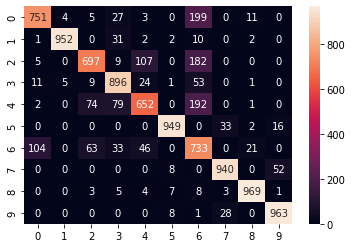

In [36]:
sns.heatmap(cm, annot=True,fmt='d')# using  annot to display the  numbers inside the cell, and using fmt(format) to avoid
# exponential format of values and using 'd'(digit) format of values

<AxesSubplot:>

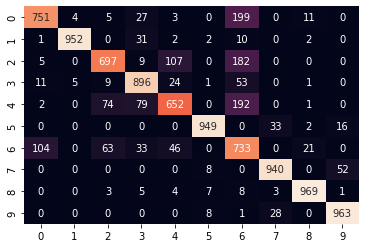

In [32]:
sns.heatmap(cm, annot=True, fmt='d', cbar=False)# removing the color bar

In [38]:
label_map.values()

dict_values(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

<AxesSubplot:>

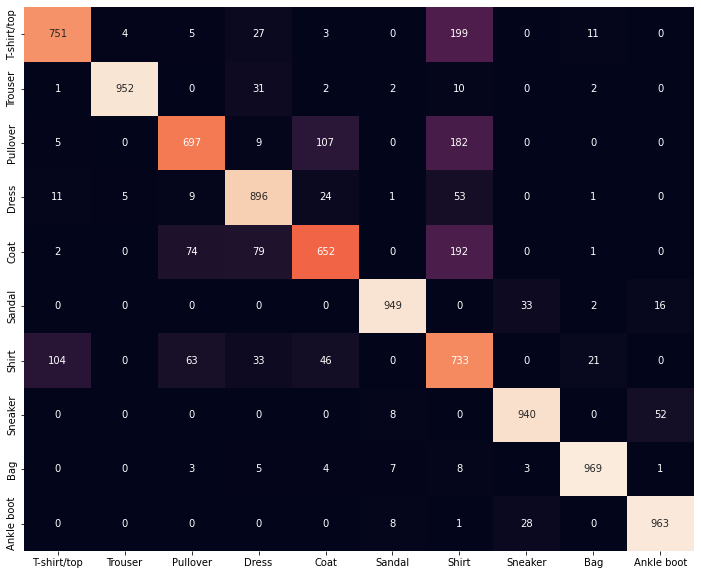

In [37]:
plt.figure(figsize = (12,10)) # increasing the fiigure size
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
           xticklabels = label_map.values(), # using labels
           yticklabels = label_map.values())

# Prediction

In [78]:
data = next(iter(test_data_loader))
print(data[0].shape) # 32 data points
print(data[1].shape) # 32 images

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [79]:
images, labels = data

In [80]:
idx = 2
img = images[idx] # taking one image from the batch of 32 images
print(img.shape)

label = labels[idx]
print(label.item())

label_map[label.item()]

torch.Size([1, 28, 28])
1


'Trouser'

In [57]:
# img.squeeze().shape

torch.Size([28, 28])

Text(0.5, 1.0, 'Trouser')

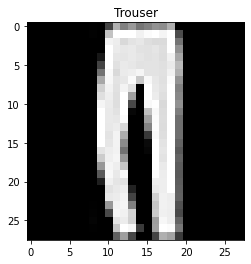

In [81]:
plt.imshow(img.squeeze(), cmap = 'gray')
plt.title(label_map[label.item()])

In [82]:
img.shape

torch.Size([1, 28, 28])

In [83]:
img = img.unsqueeze(dim=1)
model(img.to(config.DEVICE))# used when using GPU
model(img)

tensor([[  -4.1000,   20.9161,    2.4258,    2.1248,   -2.3624,  -29.8994,
          -11.5593, -111.1663,  -24.1941,  -30.0783]],
       grad_fn=<AddmmBackward0>)

In [84]:
logit = model(img)
logit

tensor([[  -4.1000,   20.9161,    2.4258,    2.1248,   -2.3624,  -29.8994,
          -11.5593, -111.1663,  -24.1941,  -30.0783]],
       grad_fn=<AddmmBackward0>)

In [88]:
# dont make any sense
sum([  -4.1000,   20.9161,    2.4258,    2.1248,   -2.3624,  -29.8994,
          -11.5593, -111.1663,  -24.1941,  -30.0783])

-187.8931

In [89]:
pred_prob = F.softmax(logit, dim = 1)
pred_prob

tensor([[1.3667e-11, 1.0000e+00, 9.3274e-09, 6.9032e-09, 7.7677e-11, 8.5334e-23,
         7.8723e-15, 0.0000e+00, 2.5639e-20, 7.1352e-23]],
       grad_fn=<SoftmaxBackward0>)

In [87]:
# makes sense
sum([1.3667e-11, 1.0000e+00, 9.3274e-09, 6.9032e-09, 7.7677e-11, 8.5334e-23,
         7.8723e-15, 0.0000e+00, 2.5639e-20, 7.1352e-23])

1.0000000163219518

In [92]:
argmax = torch.argmax(pred_prob).item()
argmax

1

In [93]:
label_map[argmax]

'Trouser'

In [101]:
def predict(data, model, label_map, device, idx = 0):
    images, labels = data
    img = images[idx]
    label = labels[idx]
    
    plt.imshow(img.squeeze(),cmap='gray')
    
#     logit = model(img) # prediction
    logit = model(img.unsqueeze(dim=1).to(config.DEVICE))
    
    pred_prob = F.softmax(logit, dim=1)
    argmax = torch.argmax(pred_prob).item()
    
    predicted_label = label_map[argmax]
    
#     actual = label_map[label]
    actual_label = label_map[label.item()]
    
    plt.title(f'actual label: {actual_label} | predicted label: {predicted_label}')
    plt.axis('off')
    return predicted_label, actual_label

('Trouser', 'Trouser')

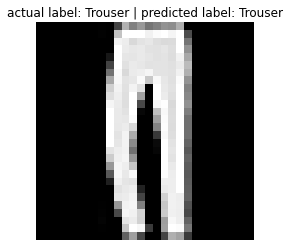

In [102]:
predict(data, model, label_map, config.DEVICE, idx=2)